# Valorant Champions Tour 2025 Analysis

## Project Overview & Business Question

This project analyzes professional matches from the 2025 Valorant Champions Tour (VCT) season, a year-long international circuit in which top VALORANT teams compete across multiple tournaments. The analysis evaluates whether commonly used team-level performance metrics provide reliable predictive signal for map outcomes when predictions are made sequentially over time.

Rather than assuming that strong performance metrics represent stable team strength, this project examines how predictive signal behaves across short and longer time horizons. By testing whether recent team performance generalizes across tournaments, the analysis aims to assess the limits and stability of commonly referenced metrics as tools for forecasting competitive outcomes. The findings are intended to inform analysts on how performance statistics should be interpreted, particularly when used for short-term evaluation versus longer-term prediction.

## Data Sources & Scope

The data used in this project is sourced from a publicly available Kaggle dataset compiled by Piyush Kumar containing match-level data from all events in the 2025 VCT season. While the dataset includes both international and regional events, this analysis is restricted to major international events, specifically Masters Toronto, Masters Bangkok, and Champions Paris, to focus on the highest tier of professional play. The analysis explicitly preserves the chronological order of matches to prevent information leakage and to reflect how performance data would be available in real-time analytical settings.

The unit of observation in this analysis is the team–match, where each row represents a single team’s performance in a given match, along with the corresponding match outcome.

Although the raw data is recorded at the player–match level, this analysis operates at the team–match level. Player statistics are aggregated within each match to construct team-level performance metrics that summarize overall team performance. This aligns the unit of analysis with the outcome of interest (win or loss), while going from player to team results.

The dataset consists of official tournament matches played under standardized competitive conditions. Because only observable in-game performance statistics are available, the analysis is limited to identifying associations only between measured team performance metrics and match outcomes and does not support causal inference. Differences in patch versions, evolving metas, or role-specific responsibilities are not explicitly controlled for and are treated as sources of potential variability.

The analysis assumes that player statistics are consistently recorded across events, that teams compete under comparable competitive incentives, and that aggregating player-level metrics provides a meaningful representation of team performance within a match. 



## Project Initialization & Data Preparation

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [254]:
m1 = pd.read_csv('Valorant Masters Bangkok 2025_csvs/player_stats.csv')
m2 = pd.read_csv('Valorant Masters Toronto 2025_csvs/player_stats.csv')
c = pd.read_csv('Valorant Champions 2025_csvs/player_stats.csv')

for idx, i in enumerate([m1, m2, c]):
       if (i['player'] == i['player_name']).all():
              print(f"player and player_name are the same for dataset {idx + 1} confirmed")
 
def cleanup(df):
       df = df[[
              # 'player', 
              'player_name', 'team', 
              # 'player_id', 'agents', 
              'agents_count','rounds', 'rating', 'acs', 'kd_ratio', 'kast', 'adr', 'kpr', 'apr',
              'fkpr', 'fdpr', 'hs_percent', 'cl_percent', 'clutches', 'k_max'
              # 'kills', 'deaths', 'assists', 'first_kills', 'first_deaths'
              ]].copy()

       df["hs_decimal"] = df["hs_percent"].str.rstrip('%').astype('float') / 100.0
       df["cl_decimal"] = df["cl_percent"].str.rstrip('%').astype('float') / 100.0
       df["kast_decimal"] = df["kast"].str.rstrip('%').astype('float') / 100.0
       df = df.drop(columns=['hs_percent', 'cl_percent', 'kast', 'clutches'])
       return df

def teamify(df):
       df = df.groupby('team')[['rating', 'acs', 'kd_ratio', 'kast_decimal', 'adr', 'kpr', 'apr', 'fkpr', 'fdpr', 'hs_decimal', 'cl_decimal', 'k_max']].mean().reset_index()
       return df


player and player_name are the same for dataset 1 confirmed
player and player_name are the same for dataset 2 confirmed
player and player_name are the same for dataset 3 confirmed


I confirmed using code that columns `player` and `player_name` are the same, so I dropped `player` for cleanliness. `player_id` was dropped since it's not needed in this analysis (since theres no players with repeated names). `agents` was ommitted as Agent selection is a strategic, player-level decision that varies by map, opponent, and meta. Because this analysis focuses on team-level performance during match execution, agent data was excluded to maintain alignment with the unit of analysis and avoid introducing complexities beyond the project's scope. `kills`, `deaths`, `assists`, `first_kills`, `first_deaths` were also ommitted from the dataframe to reduce redundancy as `adr`, `kpr`, `apr`, `fkpr` already exist as "...per round" statistics.

## Exploratory Data Analysis for Feature Selection

In [255]:
m1.head(6) # 6 7

,player,player_name,team,player_id,agents,agents_count,rounds,rating,acs,kd_ratio,kast,adr,kpr,apr,fkpr,fdpr,hs_percent,cl_percent,clutches,k_max,kills,deaths,assists,first_kills,first_deaths
0,CHICHOO,CHICHOO,EDG,15559,"['Viper', 'Vyse', 'Cypher', 'Omen']",4,313,1.23,235.6,1.27,71%,158.1,0.87,0.28,0.08,0.07,28%,22%,11/51,36,271,213,87,24,22
1,nAts,nAts,TL,457,"['Viper', 'Chamber', 'Cypher']",3,155,1.21,257.6,1.32,72%,155.1,0.91,0.19,0.09,0.12,26%,13%,3/23,25,141,107,29,14,18
2,trent,trent,G2,15500,"['Tejo', 'Sova']",2,360,1.21,220.0,1.21,75%,146.9,0.76,0.32,0.09,0.09,25%,29%,14/48,26,274,226,116,31,31
3,Derke,Derke,VIT,5022,"['Raze', 'Jett', 'Yoru']",3,225,1.18,257.2,1.20,70%,166.8,0.91,0.17,0.20,0.20,22%,31%,5/16,32,204,170,38,46,45
4,iZu,iZu,T1,29833,"['Tejo', 'Fade', 'Cypher', 'Yoru']",4,453,1.13,207.1,1.24,75%,130.6,0.75,0.21,0.11,0.09,30%,31%,19/61,21,341,276,96,48,40
5,free1ng,free1ng,DRX,1916,['Tejo'],1,149,1.10,227.3,1.16,77%,146.9,0.79,0.26,0.12,0.11,29%,7%,1/15,24,117,101,38,18,16


In [256]:
m1.dtypes

player           object
player_name      object
team             object
player_id         int64
agents           object
agents_count      int64
rounds            int64
rating          float64
acs             float64
kd_ratio        float64
kast             object
adr             float64
kpr             float64
apr             float64
fkpr            float64
fdpr            float64
hs_percent       object
cl_percent       object
clutches         object
k_max             int64
kills             int64
deaths            int64
assists           int64
first_kills       int64
first_deaths      int64
dtype: object

In [257]:
m1.columns

Index(['player', 'player_name', 'team', 'player_id', 'agents', 'agents_count',
       'rounds', 'rating', 'acs', 'kd_ratio', 'kast', 'adr', 'kpr', 'apr',
       'fkpr', 'fdpr', 'hs_percent', 'cl_percent', 'clutches', 'k_max',
       'kills', 'deaths', 'assists', 'first_kills', 'first_deaths'],
      dtype='object')

In [258]:
m1 = cleanup(m1)

In [259]:
m1.head(5)

,player_name,team,agents_count,rounds,rating,acs,kd_ratio,adr,kpr,apr,fkpr,fdpr,k_max,hs_decimal,cl_decimal,kast_decimal
0,CHICHOO,EDG,4,313,1.23,235.6,1.27,158.1,0.87,0.28,0.08,0.07,36,0.28,0.22,0.71
1,nAts,TL,3,155,1.21,257.6,1.32,155.1,0.91,0.19,0.09,0.12,25,0.26,0.13,0.72
2,trent,G2,2,360,1.21,220.0,1.21,146.9,0.76,0.32,0.09,0.09,26,0.25,0.29,0.75
3,Derke,VIT,3,225,1.18,257.2,1.20,166.8,0.91,0.17,0.20,0.20,32,0.22,0.31,0.70
4,iZu,T1,4,453,1.13,207.1,1.24,130.6,0.75,0.21,0.11,0.09,21,0.30,0.31,0.75


In [260]:
m1 = teamify(m1)

In [261]:
m1.head(100)

,team,rating,acs,kd_ratio,kast_decimal,adr,kpr,apr,fkpr,fdpr,hs_decimal,cl_decimal,k_max
0,DRX,1.000,193.860000,0.982,0.742000,128.60,0.680000,0.314,0.098,0.102000,0.272,0.098,23.0
1,EDG,1.004,198.900000,0.978,0.714000,131.66,0.702000,0.322,0.102,0.100000,0.282,0.134,27.4
2,G2,1.072,204.040000,1.070,0.748000,133.74,0.720000,0.352,0.098,0.104000,0.238,0.204,26.0
3,SEN,0.898,180.920000,0.858,0.716000,122.38,0.634000,0.292,0.098,0.106000,0.250,0.104,23.0
4,T1,0.985,195.966667,1.000,0.726667,126.80,0.681667,0.340,0.110,0.091667,0.275,0.210,23.0
5,TE,0.750,161.740000,0.672,0.606000,108.74,0.542000,0.226,0.088,0.112000,0.262,0.086,14.6
6,TL,0.976,199.160000,0.986,0.718000,130.68,0.698000,0.272,0.098,0.102000,0.278,0.106,26.2
7,VIT,0.998,198.360000,0.984,0.704000,129.00,0.694000,0.306,0.086,0.114000,0.238,0.182,24.2


In [262]:
# sanity checks for auditability
m1.info()
m1.describe().T
m1.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   team          8 non-null      object 
 1   rating        8 non-null      float64
 2   acs           8 non-null      float64
 3   kd_ratio      8 non-null      float64
 4   kast_decimal  8 non-null      float64
 5   adr           8 non-null      float64
 6   kpr           8 non-null      float64
 7   apr           8 non-null      float64
 8   fkpr          8 non-null      float64
 9   fdpr          8 non-null      float64
 10  hs_decimal    8 non-null      float64
 11  cl_decimal    8 non-null      float64
 12  k_max         8 non-null      float64
dtypes: float64(12), object(1)
memory usage: 964.0+ bytes


(8, 13)

**OK VALUES!**


### Correlation Analysis

This correlation analysis is done with the goal of identifying redundancies (if any) among the given team-level performance metrics. This is done to guide principled feature selection for subsequent modeling. By examining the relationships between metrics, the goal is to retain a small set of complementary features that capture distinct dimensions of performance while avoiding overlapping or collinear measures that would add little additional information.

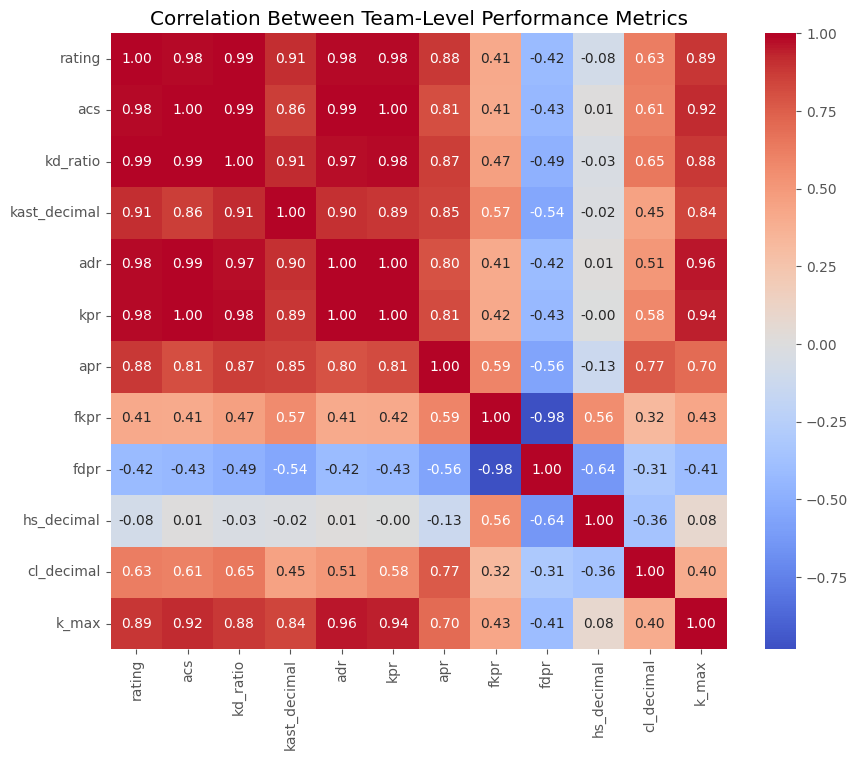

In [263]:
plt.figure(figsize=(10,8))
sns.heatmap(
    m1.drop(columns=["team"]).corr(),
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    square=True
)
plt.title("Correlation Between Team-Level Performance Metrics")
plt.show()

This team-level exploratory analysis reveals substantial redundancy among combat-oriented metrics such as ACS, ADR, KPR, and K/D ratio, suggesting they are overlapping measures of offensive output. In contrast, consistency-related metrics, including KAST and clutch success rate, exhibit weaker correlations with raw combat statistics, suggesting they capture distinct aspects of team performance. First-kill and first-death rates show a strong inverse relationship, reflecting the opposing outcomes of opening engagements. Notably, headshot rate displays little correlation with either combat output or consistency metrics, indicating that mechanical precision alone does not distinguish stronger teams at the aggregate level. Together, these patterns motivate the selection of a small, complementary subset of features for subsequent match-level analysis.

**On Feature Availability:**

Following exploratory analysis, a small set of complementary team-level performance metrics was selected to minimize redundancy while capturing distinct dimensions of in-game performance. Because round-level exposure could be reconstructed from match data, all selected metrics were normalized on a per-round basis to ensure comparability across matches.

**Average Combat Score (acs)** comes in as a representative measure of offensive output. ACS integrates damage dealt and kill impact into a single per-round statistic and exhibited strong correlations with other combat-oriented metrics such as ADR, KPR, and K/D ratio. Retaining ACS captures the dominant offensive signal while avoiding redundancy and additional assumptions embedded in composite indices such as rating.

**KAST (kast_decimal)**
is included to capture round-level consistency by accounting for kills, assists, survivability, and trading. KAST showed weaker correlations with raw combat metrics during exploratory analysis, indicating that it reflects a distinct dimension of team performance related to coordinated execution rather than sheer fragging volume.

**First kills per round (fkpr)**
is added to represent early-round advantage. Opening engagements in VALORANT have immediate implications for round state, map control, and economy. Because first kills and first deaths were found to be almost perfectly inversely correlated, only first kills per round were retained to avoid redundancy while preserving interpretability.

Together, these features capture offensive impact, consistency, and early-round control, providing a principled and interpretable foundation for match-level predictive analysis.

Although **clutch performance** was explored during EDA, consistent round-level clutch indicators were not available for match-level modeling and were therefore excluded.

## Modeling Data Preparation

In [264]:
m1dmps = pd.read_csv('Valorant Masters Bangkok 2025_csvs/detailed_matches_player_stats.csv')
m2dmps = pd.read_csv('Valorant Masters Toronto 2025_csvs/detailed_matches_player_stats.csv')
cdmps = pd.read_csv('Valorant Champions 2025_csvs/detailed_matches_player_stats.csv')

m1dmm = pd.read_csv('Valorant Masters Bangkok 2025_csvs/detailed_matches_maps.csv')
m2dmm = pd.read_csv('Valorant Masters Toronto 2025_csvs/detailed_matches_maps.csv')
cdmm = pd.read_csv('Valorant Champions 2025_csvs/detailed_matches_maps.csv')

In [265]:
def cleanup2(df):
       df = df[['match_id', 
       'event_name', 
       #'event_stage', 
       'match_date', 
       'team1', 'team2',
       'score_overall', 'player_name', 
       # 'player_id', 
       'player_team', 'stat_type',
       #'agent', 'rating', 
       'acs', 
       #'k', 'd', 'a', 'kd_diff',
       'kast', 
       #'adr',
       #'hs_percent', 
       'fk',
       #'fd', 'fk_fd_diff', 
       'map_name', 'map_winner'
       ]].copy()
       
       df["kast_decimal"] = df["kast"].str.rstrip('%').astype('float') / 100.0
       df = df.drop(columns=['kast'])
       df["match_date"] = pd.to_datetime(df["match_date"])
       df = df[df['stat_type'] != 'overall']
       for i in showmatch_ids:
              df = df[df['match_id'] != i]
       return df

def teamify2(df):
       df = df.groupby(["stat_type", "match_id", 'event_name', 'match_date',"map_name", "player_team", "map_winner"])[stat].mean().reset_index()
       df['map_win'] = (df['player_team'] == df['map_winner']).astype(int)
       df = df.drop(columns=['map_winner'])
       return df

def combine(mm, mps):
       mm["total_rounds"] = mm['score'].str.split(' - ').apply(lambda x: int(x[0]) + int(x[1]))
       mps = mps.merge(mm[['match_id', 'map_name', 'total_rounds']], on=['match_id', 'map_name'], how='left')
       mps["fkpr"] = mps['fk'] / mps['total_rounds']
       mps = mps.drop(columns=['total_rounds', 'stat_type'])
       return mps

def check(df):
       winnerspermap = df.groupby(['match_id', 'map_name'])['map_win'].sum()

       if (winnerspermap == 1).all():
              print("All maps have exactly one winning team - check passed")
       else:
              print("check failed")

       print("Null Values:")
       return (df[['acs', 'kast_decimal', 'fkpr']].isna().sum())

stat = ['acs', 'kast_decimal', 'fk']
showmatch_ids = [450589, 507067]


In [266]:
m1dmps = cleanup2(m1dmps)
m1dmps = teamify2(m1dmps)
m1dmps = combine(m1dmm, m1dmps)
check(m1dmps)

All maps have exactly one winning team - check passed
Null Values:


acs             0
kast_decimal    0
fkpr            0
dtype: int64

In [267]:
m2dmps = cleanup2(m2dmps)
m2dmps = teamify2(m2dmps)
m2dmps = combine(m2dmm, m2dmps)
check(m2dmps)

All maps have exactly one winning team - check passed
Null Values:


acs             0
kast_decimal    0
fkpr            0
dtype: int64

In [268]:
cdmps = cleanup2(cdmps)
cdmps = teamify2(cdmps)
cdmps = combine(cdmm, cdmps)
check(cdmps)

All maps have exactly one winning team - check passed
Null Values:


acs             0
kast_decimal    0
fkpr            0
dtype: int64

## Modeling Setup

In [269]:
edfs = {"m1": m1dmps,
        "m2": m2dmps,
        "c": cdmps}

rolling_window = 5
min_periods = 3

def processdfs(dfs): #  list btw
    df = pd.concat(dfs, ignore_index=True)
    df = df.sort_values(by="match_date")

    df["acs_hist"] = (
    df.groupby("player_team")["acs"]
          .shift(1)
          .rolling(rolling_window, min_periods=min_periods)
          .mean()
    )

    df["kast_hist"] = (
        df.groupby("player_team")["kast_decimal"]
            .shift(1)
            .rolling(rolling_window, min_periods=min_periods)
            .mean()
    )

    df["fkpr_hist"] = (
        df.groupby("player_team")["fkpr"]
            .shift(1)
            .rolling(rolling_window, min_periods=min_periods)
            .mean()
    )

    df = df.dropna(
        subset=["acs_hist", "kast_hist", "fkpr_hist"]
)
    return df

events = {"m1": "Valorant Masters Bangkok 2025", #  somthin like events[m1] = "Valorant Masters Bangkok 2025"
          'm2': "Valorant Masters Toronto 2025", 
          'c': "Valorant Champions 2025"}

def predict(df, train_event, test_event):

    if isinstance(train_event, list):
        train = df[df["event_name"].isin(train_event)]
    else:
        train = df[df["event_name"] == train_event]
    if isinstance(test_event, list):
        test = df[df["event_name"].isin(test_event)]
    else:
        test = df[df["event_name"] == test_event]
        
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_auc_score

    features = ["acs_hist", "kast_hist", "fkpr_hist"]

    X_train = train[features]
    y_train = train["map_win"]
    X_test  = test[features]
    y_test  = test["map_win"]

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    
    model = LogisticRegression()
    model.fit(X_train_s, y_train)

    pred = model.predict(X_test_s)
    prob = model.predict_proba(X_test_s)[:, 1]

    print(f"Accuracy: {accuracy_score(y_test, pred)}, ROC AUC score: {roc_auc_score(y_test, prob)}")

## Temporal Generalization Across VCT Events

To test whether team-level performance metrics generalize across competitive contexts, the models were trained on earlier VCT events and evaluated on events using strict chronological splits. Rolling features are used to represent recent team form, ensuring no future information leakage.

### Train on M1 Bangkok, Test on M2 Toronto

In [270]:
train_m1_test_m2 = processdfs([edfs["m1"], edfs["m2"]])
predict(train_m1_test_m2, events["m1"], events["m2"])

Accuracy: 0.5258620689655172, ROC AUC score: 0.5194766577460601


### Train on M2 Toronto, Test on C Paris

In [271]:
train_m2_test_c = processdfs([edfs["m2"], edfs["c"]])
predict(train_m2_test_c, events["m2"], events["c"])

Accuracy: 0.4943181818181818, ROC AUC score: 0.45674070247933884


### Train on M1 Bangkok + M2 Toronto, Test on C Paris

In [272]:
train_m1m2_test_c = processdfs([edfs["m1"], edfs["m2"], edfs["c"]])
predict(train_m1m2_test_c, [events["m1"], events["m2"]], events["c"])

Accuracy: 0.4943181818181818, ROC AUC score: 0.4856663223140496


### Interpretation

This analysis evaluates whether a team’s recent match performance provides predictive signal for upcoming map outcomes when predictions are made sequentially over time. Features are constructed using rolling summaries of prior matches, ensuring that each prediction relies strictly on information that would have been available before the map was played.

Model performance is assessed relative to a random baseline across multiple temporal splits. When predicting Masters Toronto, performance is modestly above random (accuracy ≈ 0.53, ROC-AUC ≈ 0.52), indicating the presence of weak short-term predictive signal. However, this signal does not persist when forecasting later events, where performance degrades to near-random levels. Extending the available history to include additional prior tournaments does not materially improve results, suggesting that older performance does not reinforce predictive power once more recent data is available.

### Why could this be?

Several factors likely contribute to the observed instability of predictive signal. Professional VALORANT operates in a rapidly changing environment, where both the game and its competitive landscape evolve continuously. Balance updates, new agents, and map rotations alter gameplay conditions, while teams simultaneously adapt through strategy changes, roster adjustments, and opponent-specific preparation. These shifts mean that performance observed under one set of conditions may not remain informative under the next.

As a result, short-term performance metrics tend to capture situational form rather than enduring team quality. This helps explain why limited predictive signal appears over short horizons but fails to generalize across later tournaments. In addition, map-level outcomes compress many high-variance in-game factors like pistol rounds, clutches, and economy into a single win–loss outcome. Because many of these influences are not represented in aggregate performance statistics, a portion of outcome variation remains unexplained, limiting the reliability of historical metrics for longer-term prediction.

## Conclusions and Recommendations

Overall, the results indicate that recent team performance metrics provide limited short-term insight into upcoming match outcomes but do not function as reliable indicators of sustained competitive advantage across tournaments. Performance statistics should therefore be interpreted as context-dependent signals rather than stable measures of team strength.

From an analytical perspective, these findings suggest that performance metrics are best suited for short-horizon evaluation rather than long-term forecasting. Models that assume strong carryover of performance across tournaments risk overstating predictive confidence, and richer contextual features may be required to improve robustness over longer time horizons.

## Limitations

Observed relationships reflect average patterns across teams and do not imply that the same performance factors are equally influential for every individual team. The analysis operates at the map level using binary win–loss outcomes, which compresses many in-game dynamics into a single label. Additionally, the feature set is limited to aggregate performance metrics and does not account for strategic, compositional, or contextual factors that may meaningfully influence match outcomes. As a result, findings should be interpreted as descriptive and predictive rather than causal.